In [40]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import sys
sys.path.append('../creme/')
import custom_model
import creme
import utils
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pyranges as pr
import shutil
import pickle, os
from sklearn.metrics import mean_squared_error
import itertools
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
cell_lines = ['PC-3', 'GM12878', 'K562']
model_name = 'enformer'
optimization_name = 'max'
_, cre_tiles = utils.set_tile_range(custom_model.Enformer().seq_length, 5000)
N_iters = 25

pdf_base_dir = utils.make_dir('pdfs')
pdf_dir = utils.make_dir(f'{pdf_base_dir}/higher_order_test/')
summary_csv_dir = f'../results/summary_csvs/enformer/greedy_search/'

# Heatmaps of CRE locations

In [27]:
location_maps = pd.read_csv(f"{summary_csv_dir}/{optimization_name}_locations.csv")

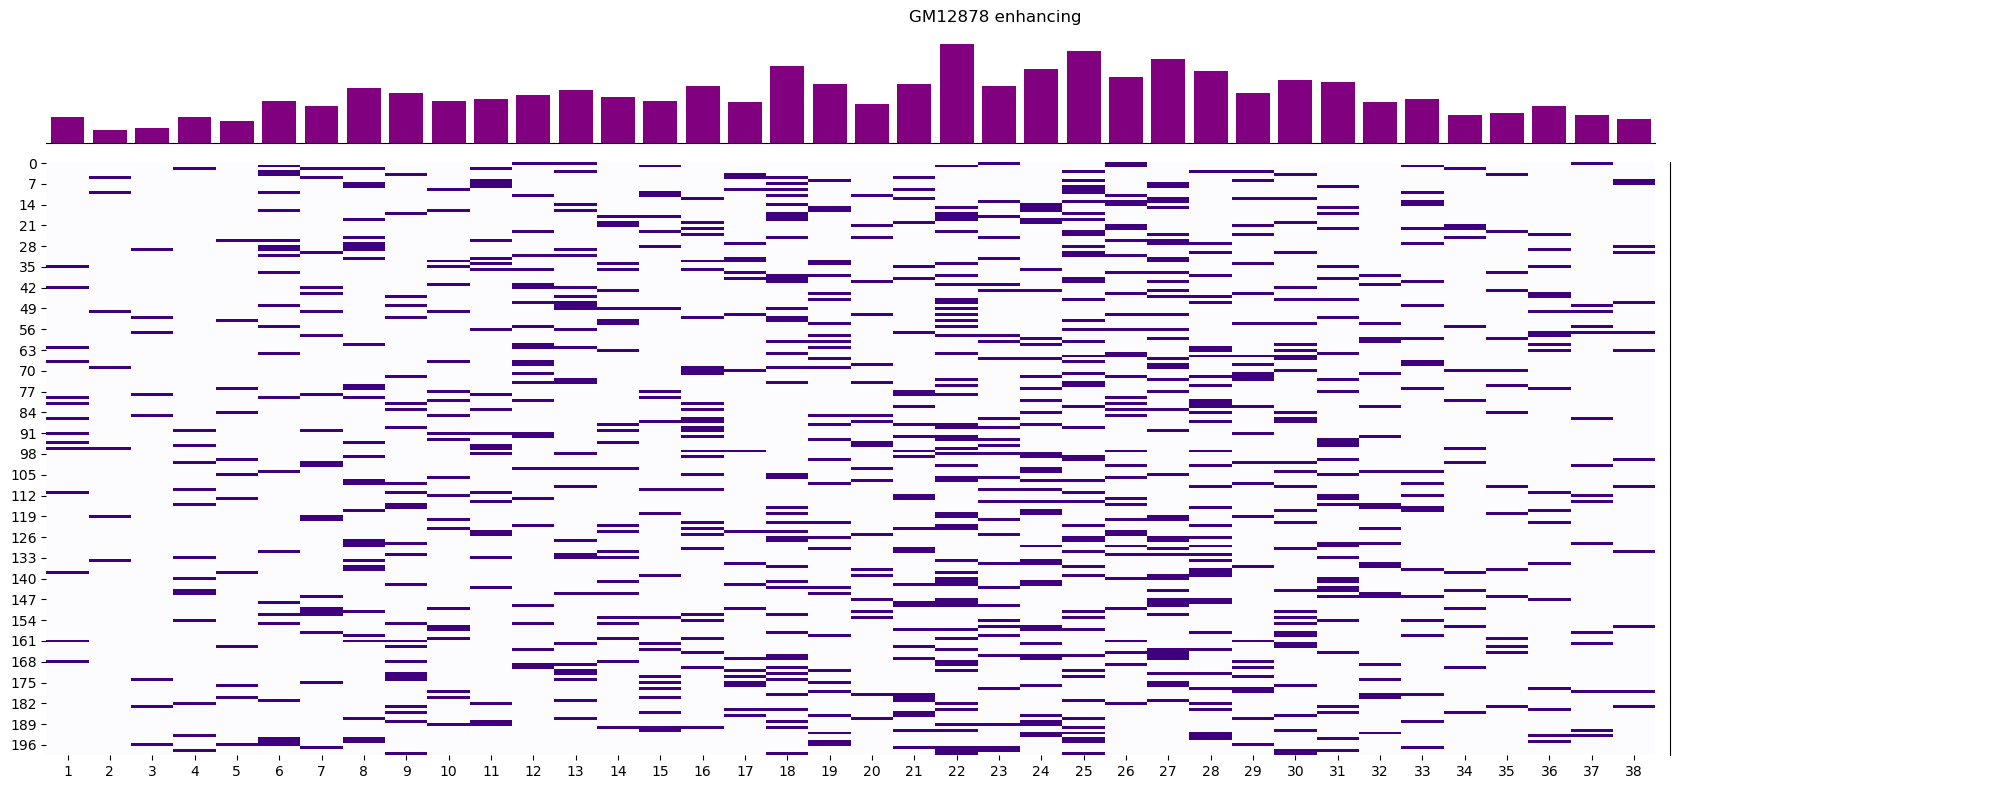

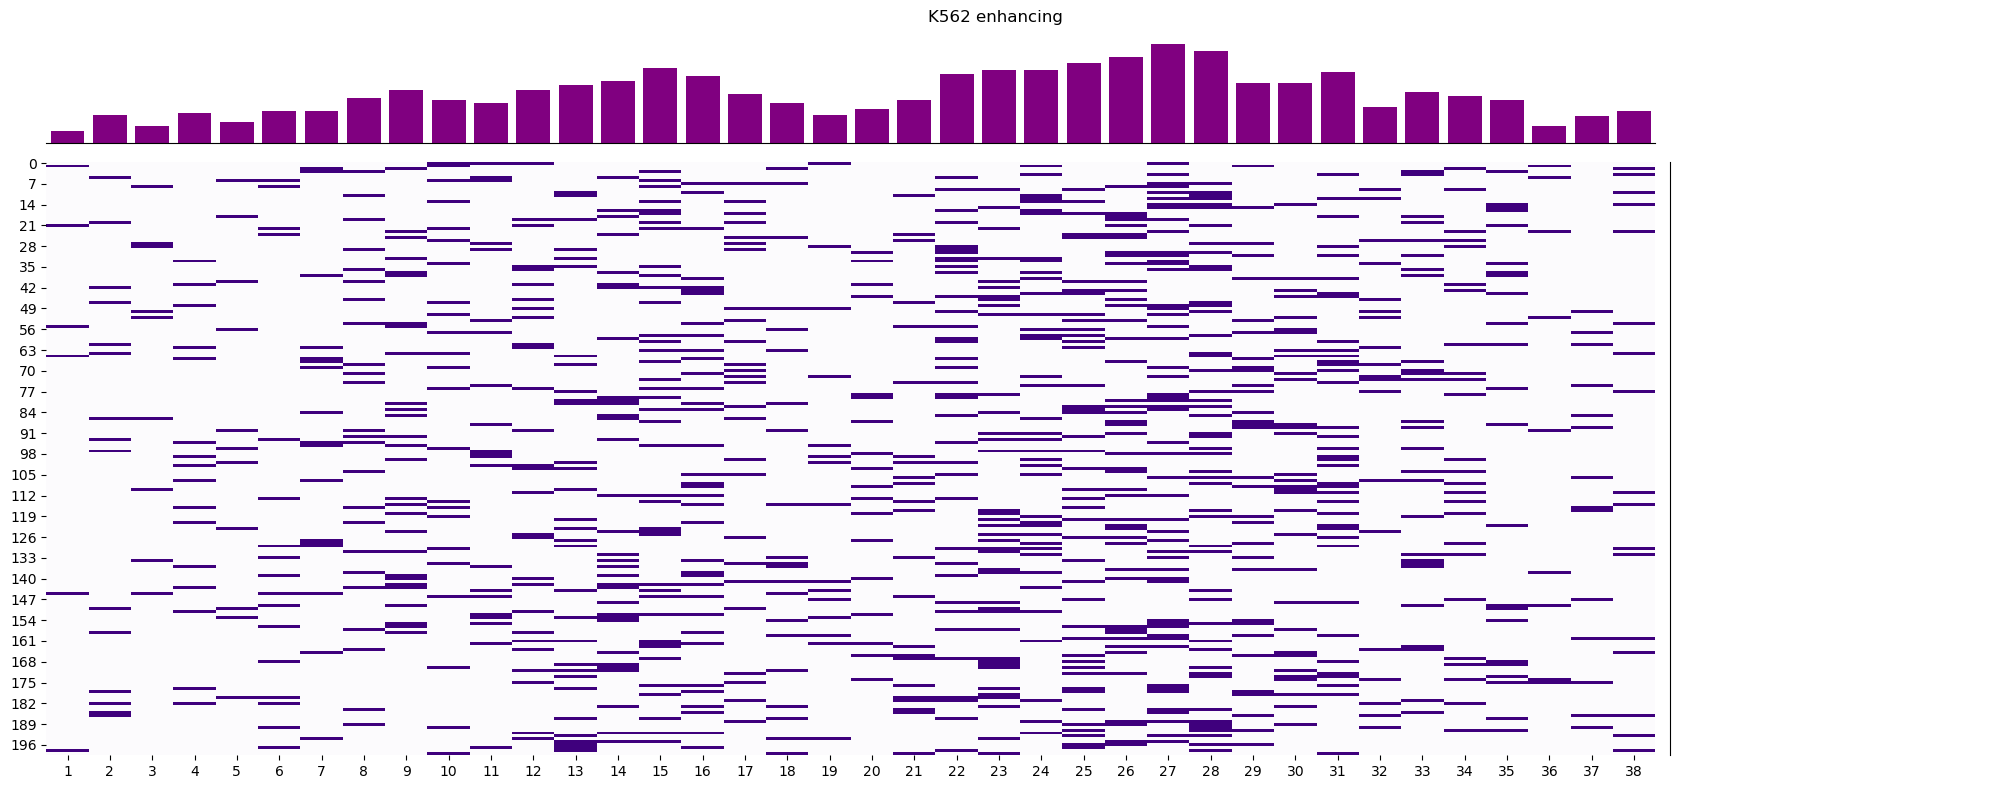

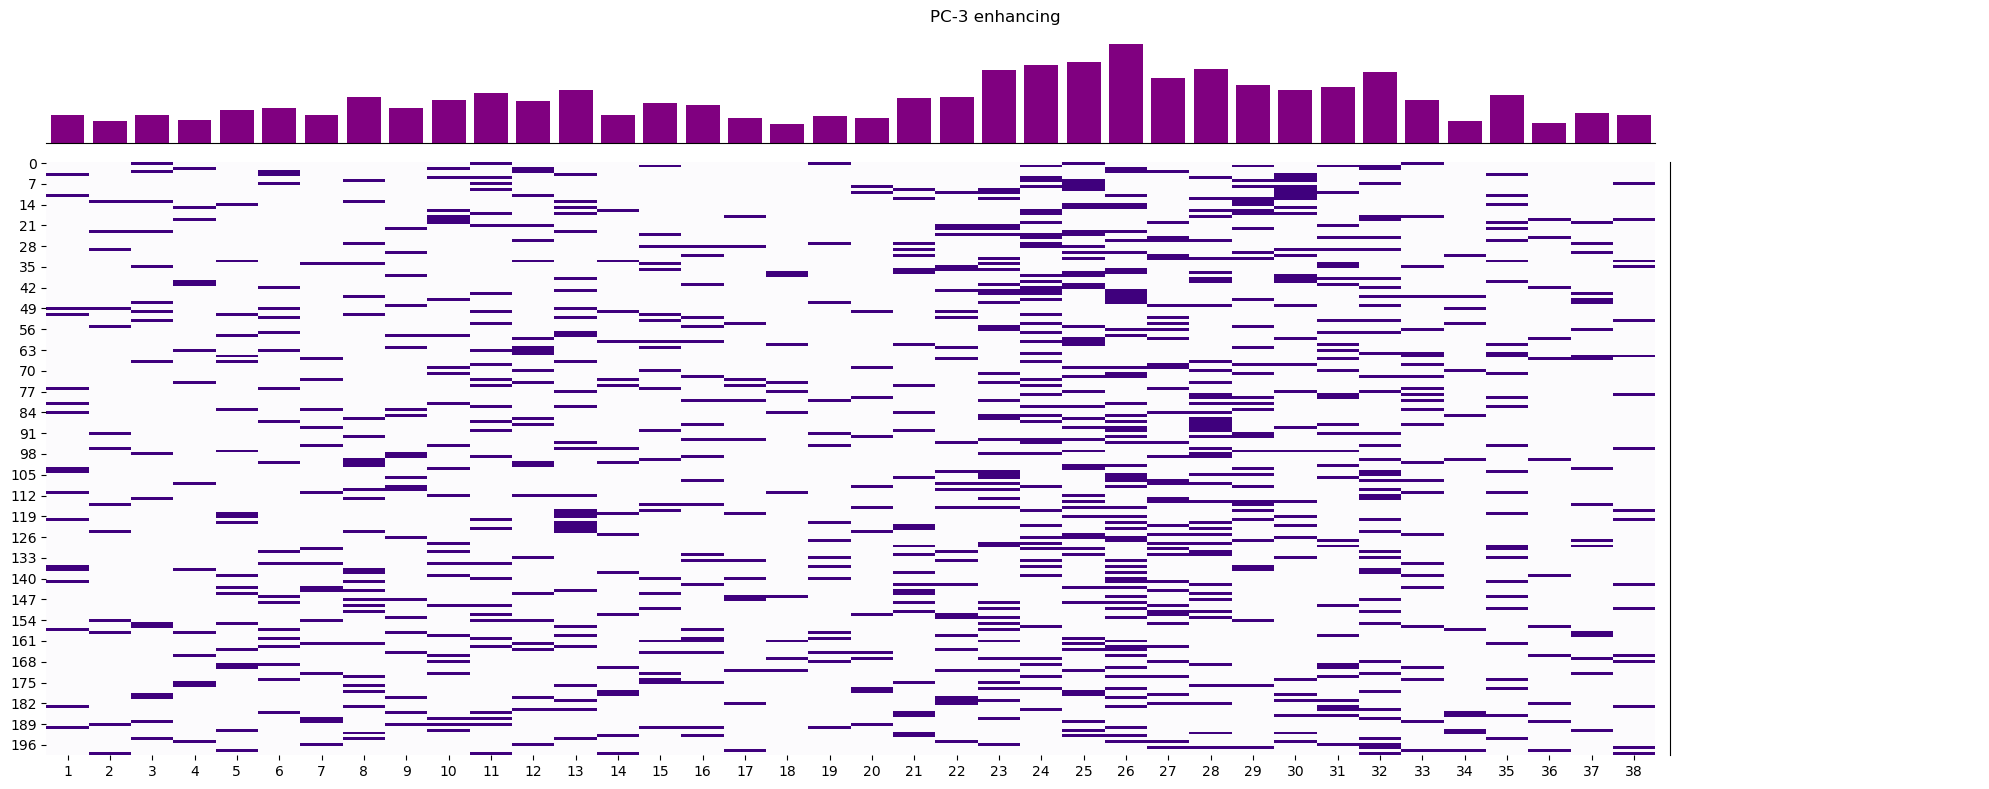

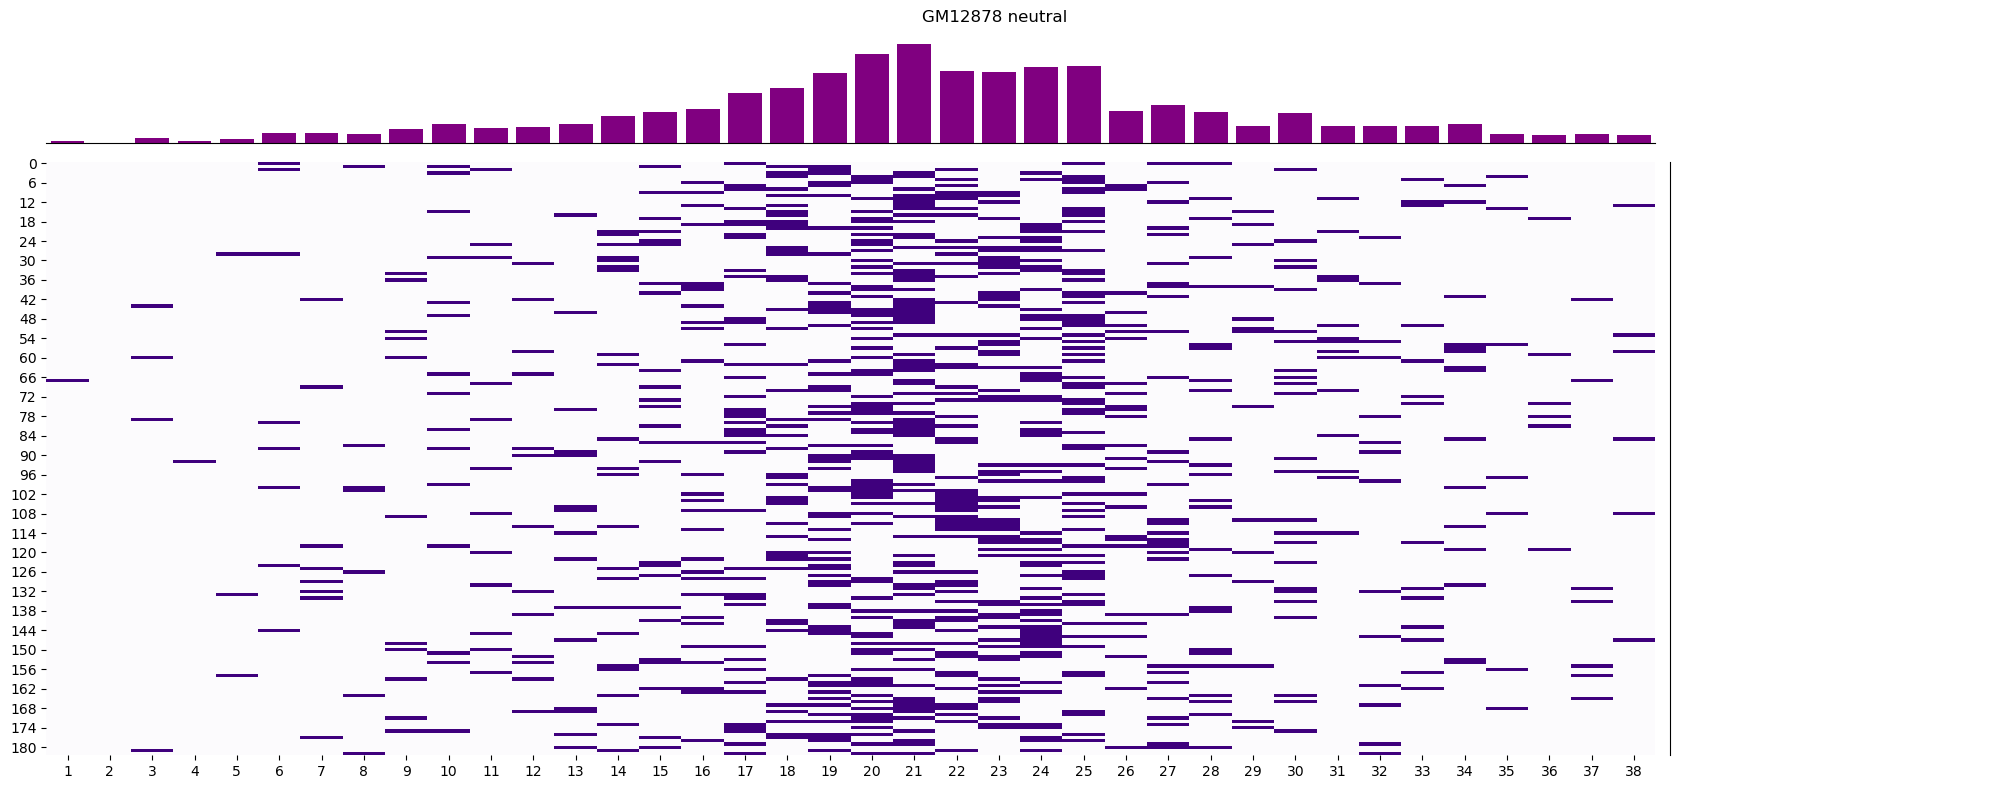

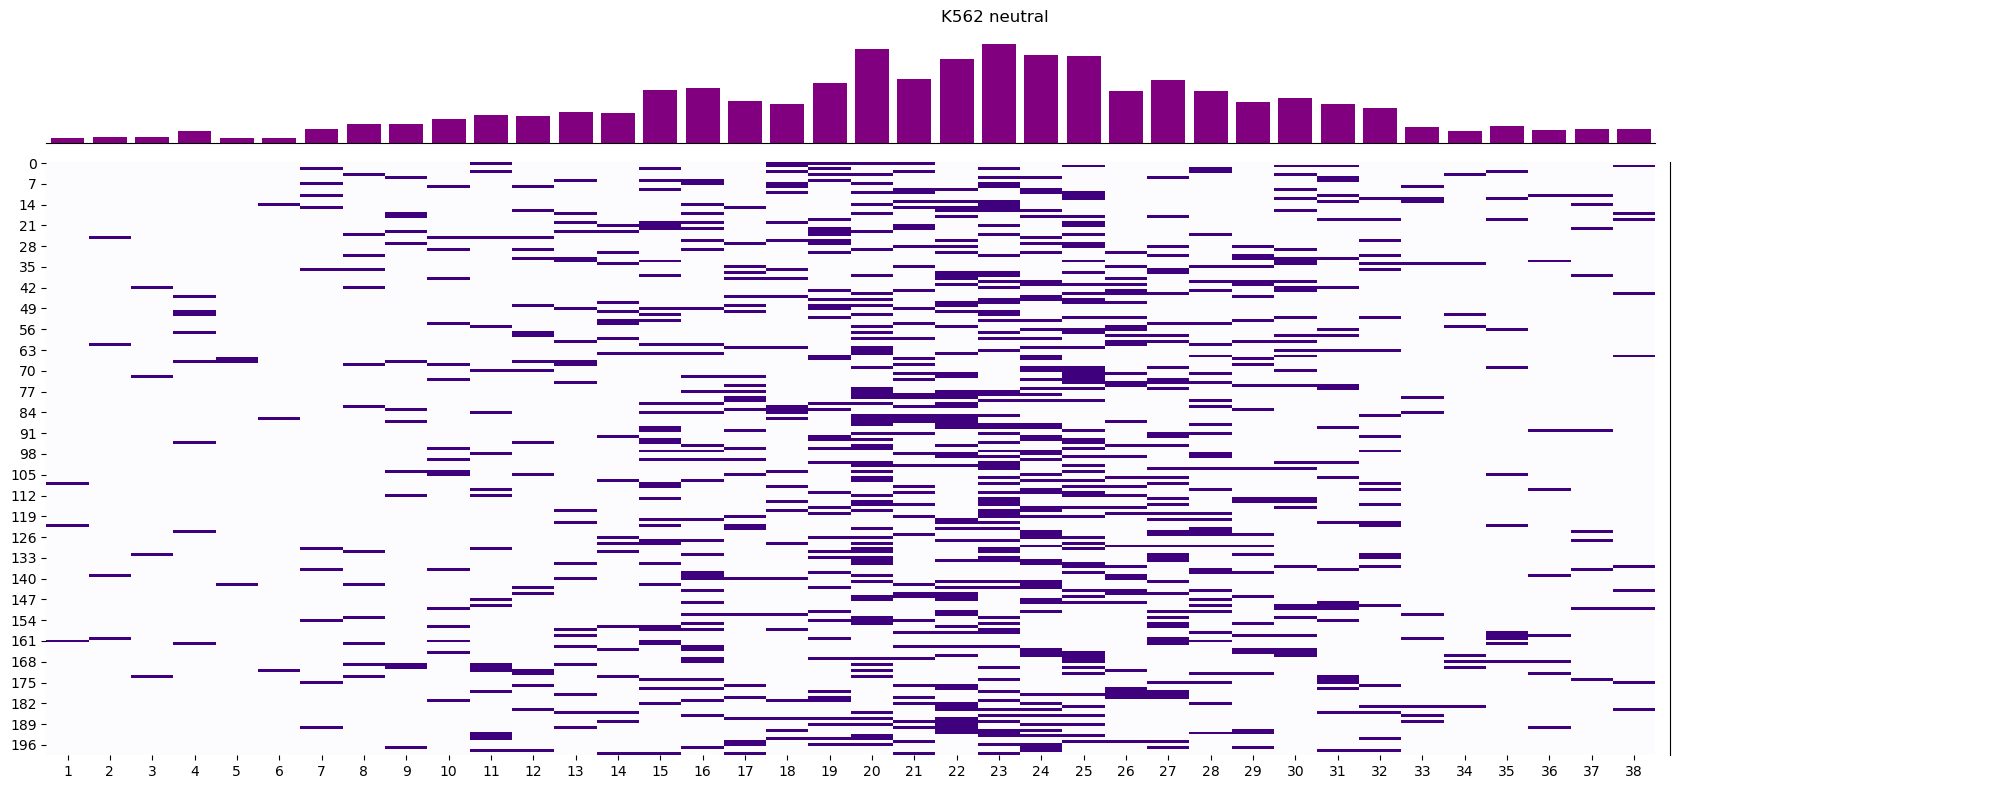

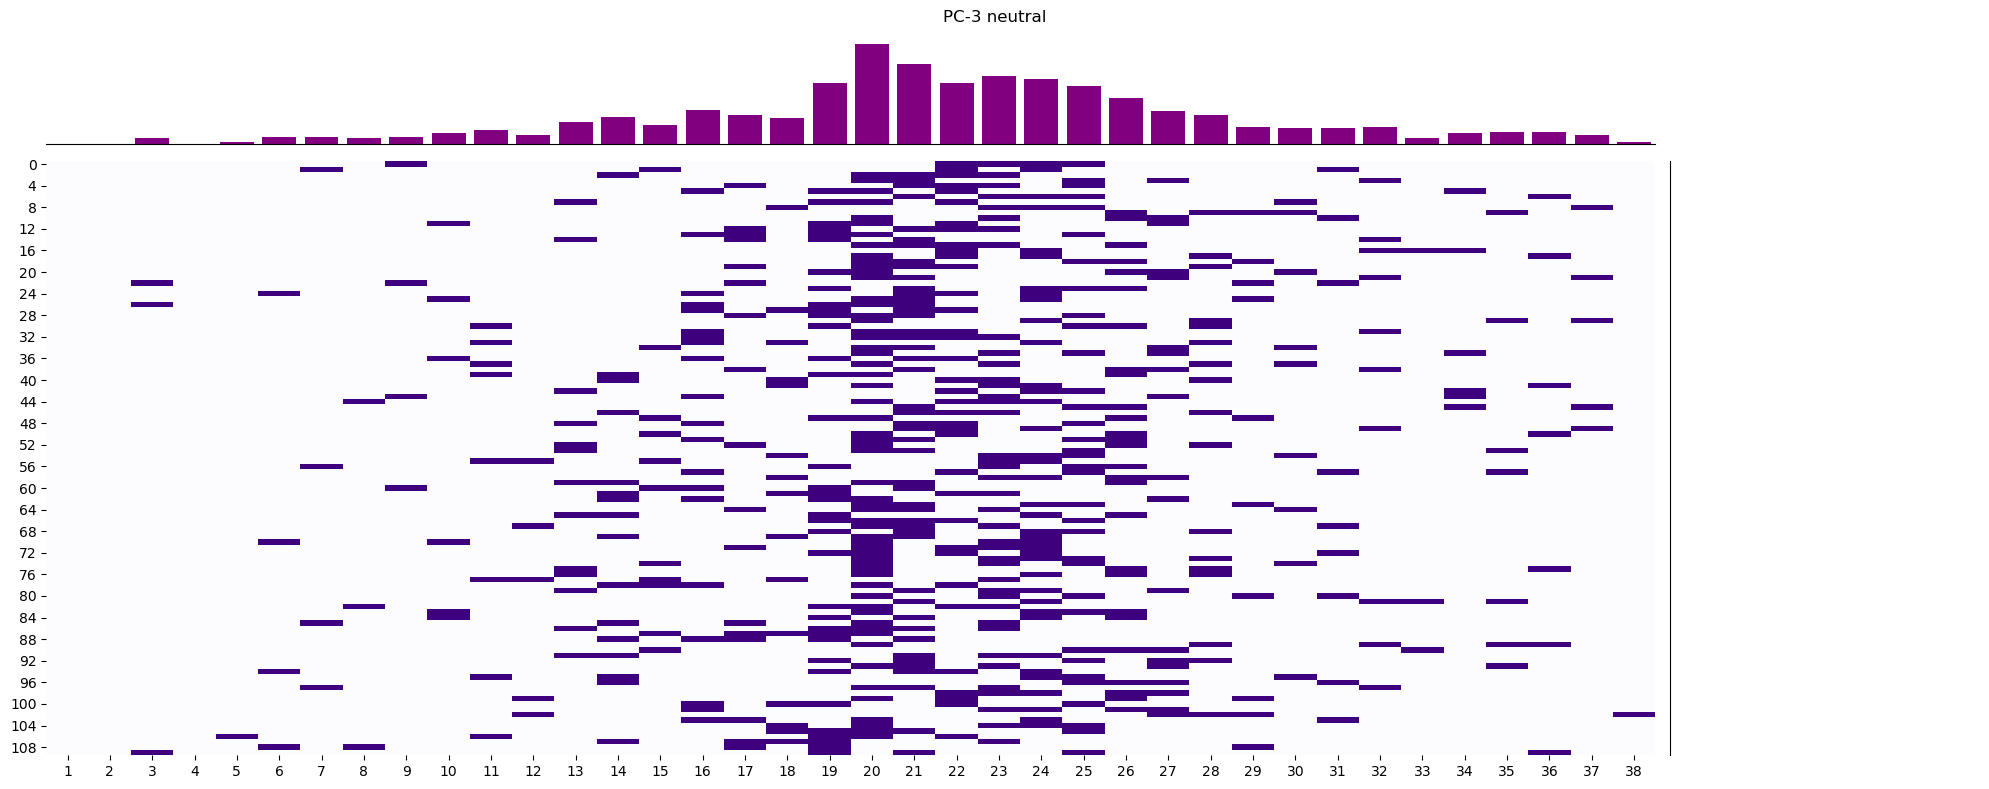

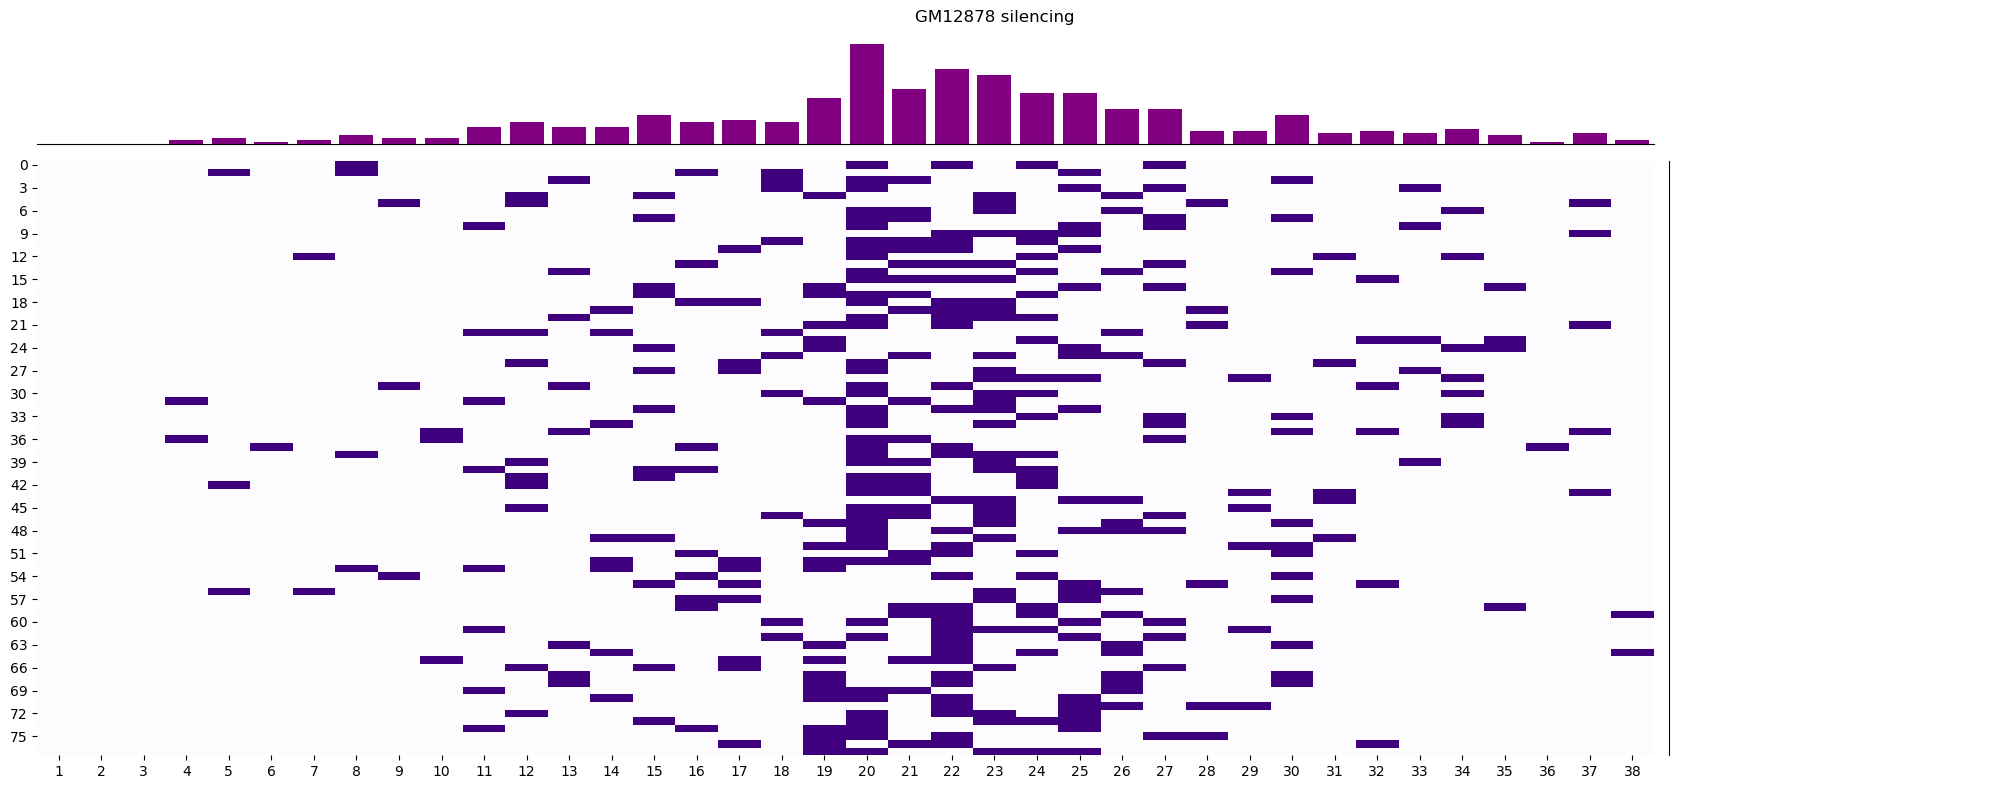

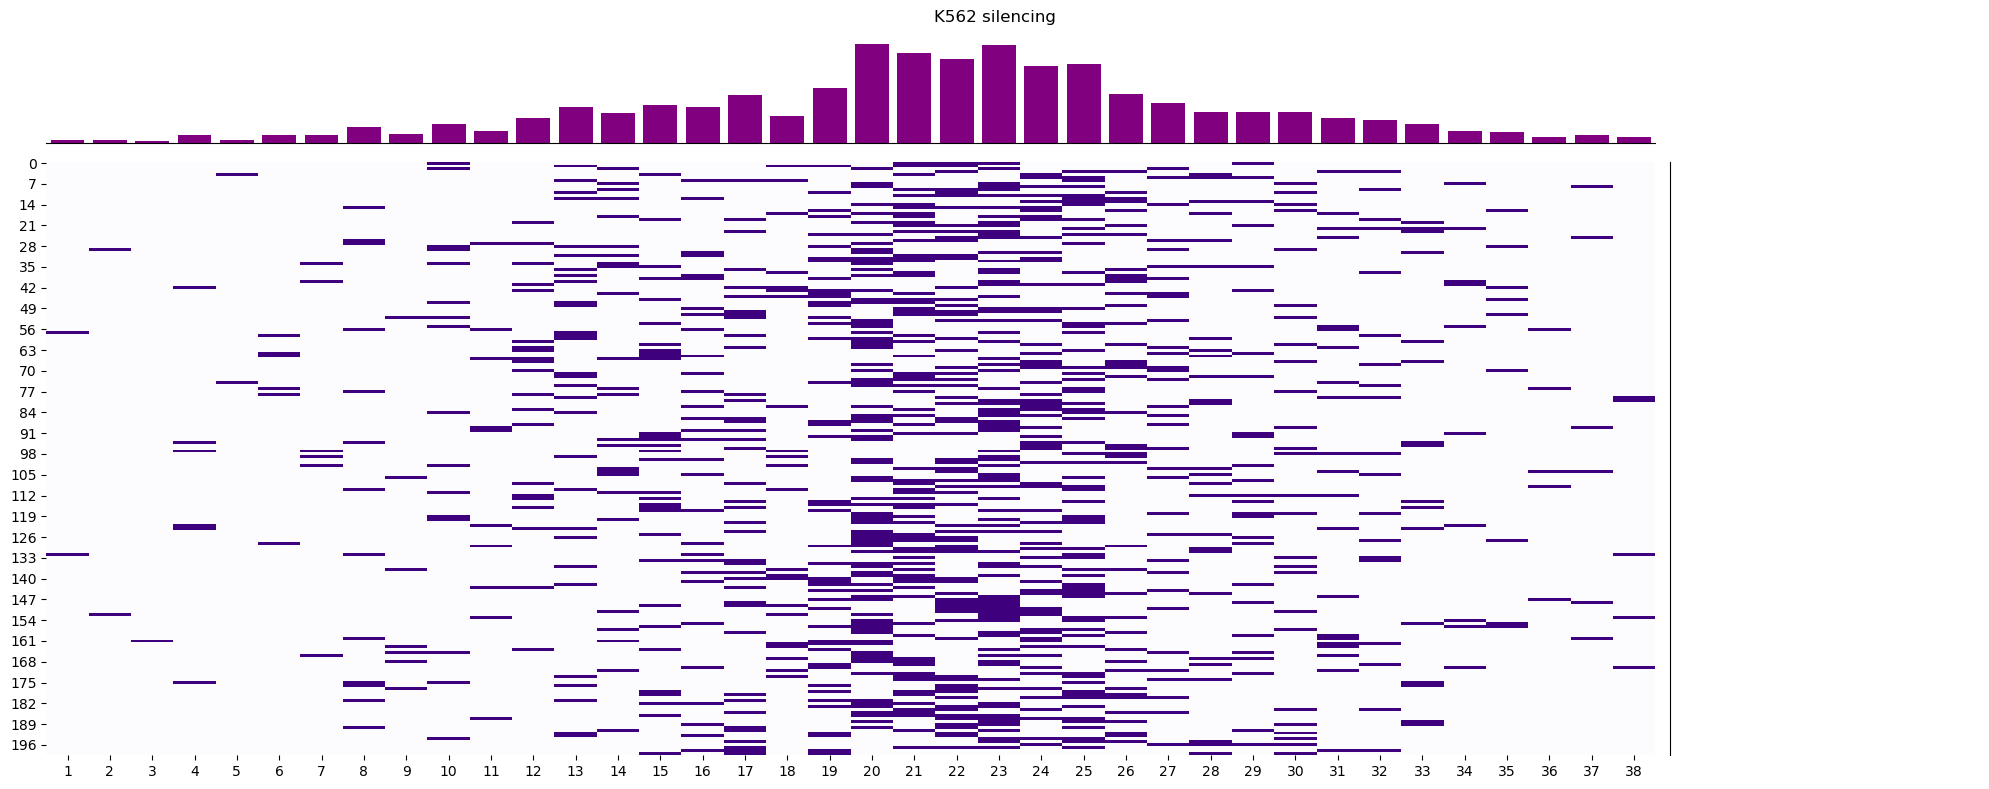

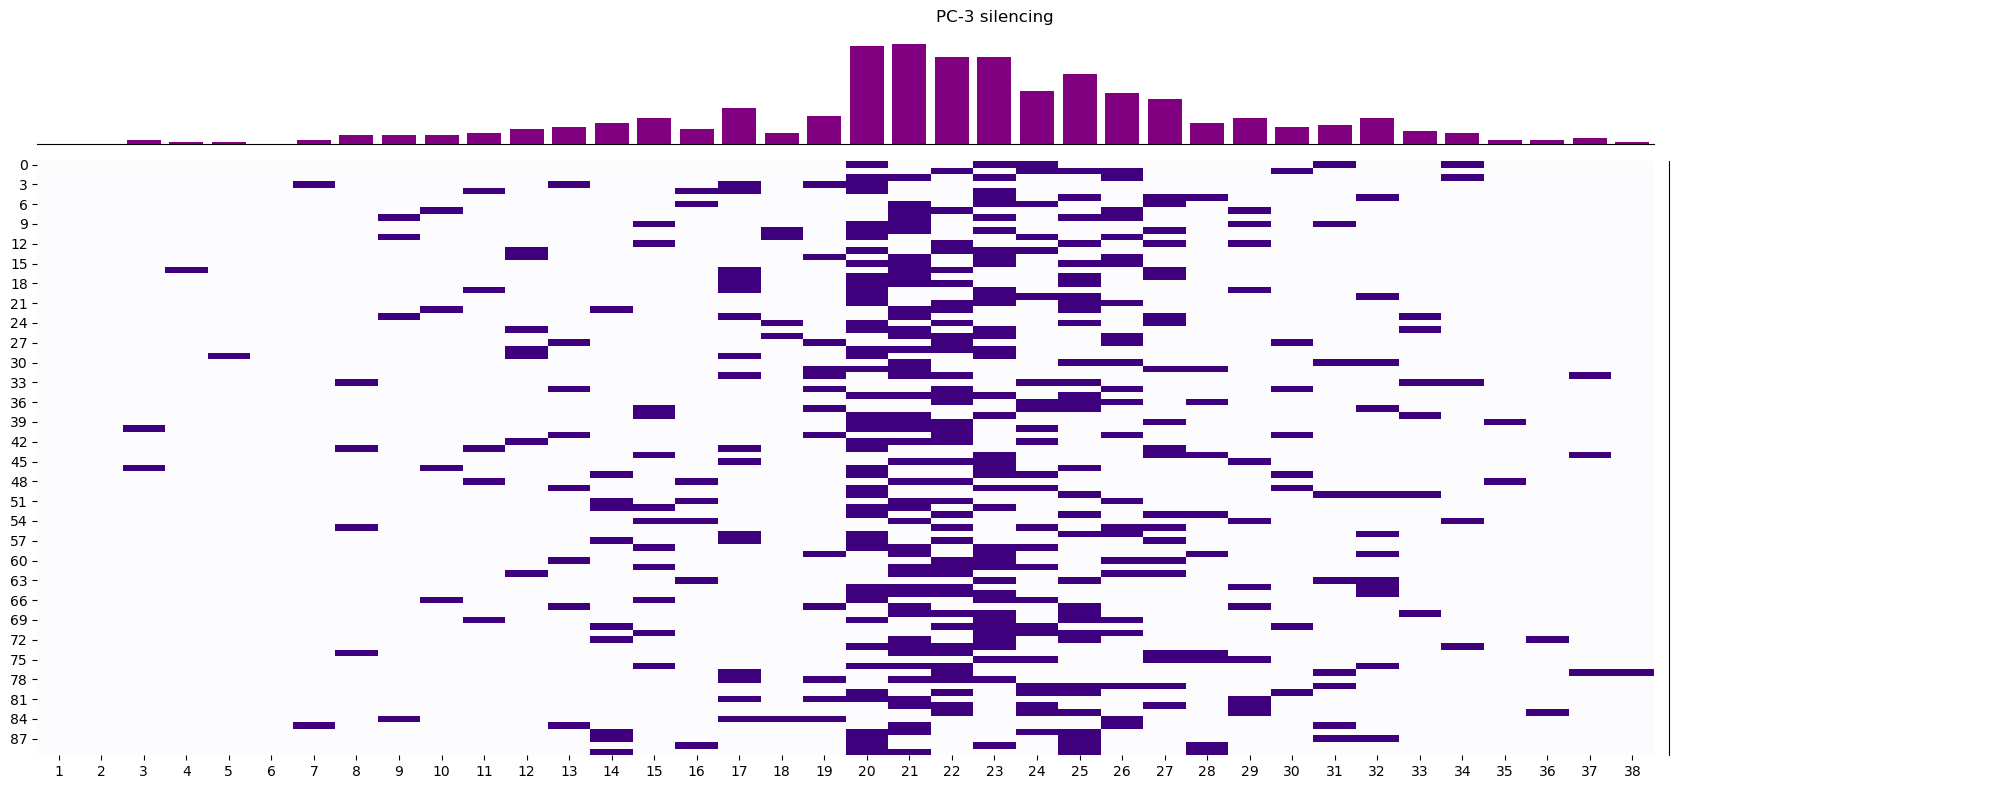

In [28]:
for (context, cell_line), context_maps in location_maps.groupby(['context', 'cell_line']):
    
    v = context_maps['tile_selected'].values.reshape((context_maps.shape[0]//38, 38))
    df = pd.DataFrame(v)
    H, D = df.shape
    df = df.reset_index(names='sequence').melt(id_vars='sequence', var_name='position', value_name='Selected')
    
    df['position'] = [int(p) for p in df['position']]
    g = sns.jointplot(data=df, x='position', y='sequence', kind='hist', bins=(D, H))
    g.ax_marg_y.cla()
    g.ax_marg_x.cla()
    sns.heatmap(data=df['Selected'].to_numpy().reshape(D, H).T.astype('float'), ax=g.ax_joint, cbar=False, cmap='Purples')
    
    # g.ax_marg_y.barh(np.arange(0.5, H), df.groupby(['hour'])['Cost Dif.'].sum().to_numpy(), color='navy')
    g.ax_marg_x.bar(np.arange(0.5, D), df.groupby(['position'])['Selected'].sum().to_numpy(), color='purple')
    
    g.ax_joint.set_xticks(np.arange(0.5, D))
    g.ax_joint.set_xticklabels(range(1, D + 1), rotation=0)
    # g.ax_joint.set_yticks(np.arange(0.5, H))
    # g.ax_joint.set_yticklabels(range(H), rotation=0)
    
    # remove ticks between heatmao and histograms
    g.ax_marg_x.tick_params(axis='x', bottom=False, labelbottom=False)
    g.ax_marg_y.tick_params(axis='y', left=False, labelleft=False)
    # remove ticks showing the heights of the histograms
    g.ax_marg_x.tick_params(axis='y', left=False, labelleft=False)
    g.ax_marg_y.tick_params(axis='x', bottom=False, labelbottom=False)
    
    g.fig.set_size_inches(20, 8)  # jointplot creates its own figure, the size can only be changed afterwards
    # g.fig.subplots_adjust(hspace=0.3) # optionally more space for the tick labels
    g.fig.subplots_adjust(hspace=0.05, wspace=0.02)  # less spaced needed when there are no tick labels
    g.fig.suptitle(f'{cell_line} {context}')
    plt.tight_layout()

    plt.savefig(f'{pdf_dir}/silencer_distribution_{cell_line}_{context}.pdf')
    plt.show()


# Traces

In [29]:
all_traces = pd.read_csv(f'{summary_csv_dir}/{optimization_name}_traces.csv', index_col='Unnamed: 0')

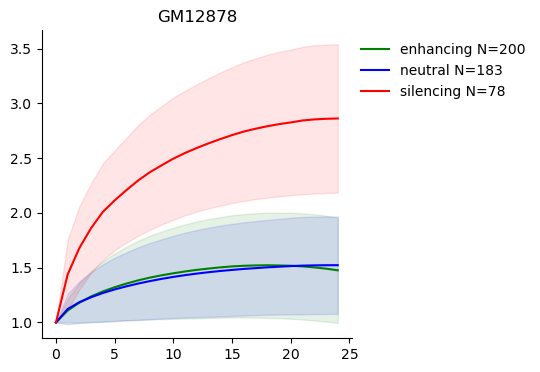

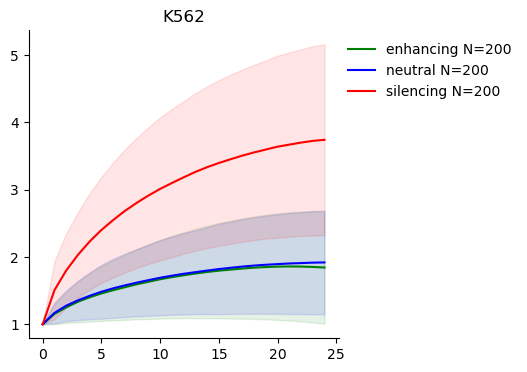

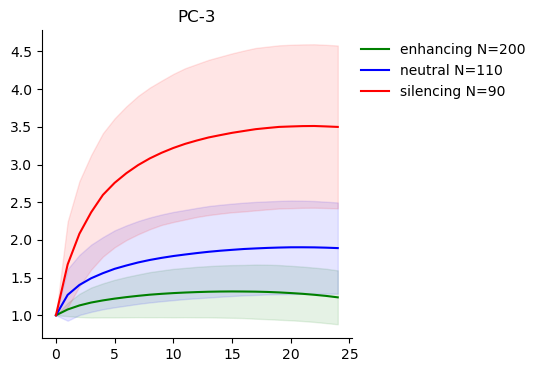

In [30]:
color_map = {'enhancing': 'g', 'neutral':'b', 'silencing':'r'}
for (cell_line), all_context_data in all_traces.groupby('cell_line'):

    fig, ax = plt.subplots(1, 1, figsize=[4,4])
    for context, data in all_context_data.groupby('context'):
        data = data['trace'].values.reshape((data.shape[0]//N_iters, N_iters))
    
        mean = data.mean(axis=0)
        std = data.std(axis=0)
        color = color_map[context]
        ax.plot(mean, c=color, alpha=1, label=f'{context} N={data.shape[0]}')
        ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)

    plt.legend(frameon=False, bbox_to_anchor=[1.6,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.title(cell_line)
    # fig.savefig(f'{pdf_dir}/{cell_line}_enhancer_search.pdf')

# Hypothetical additive model

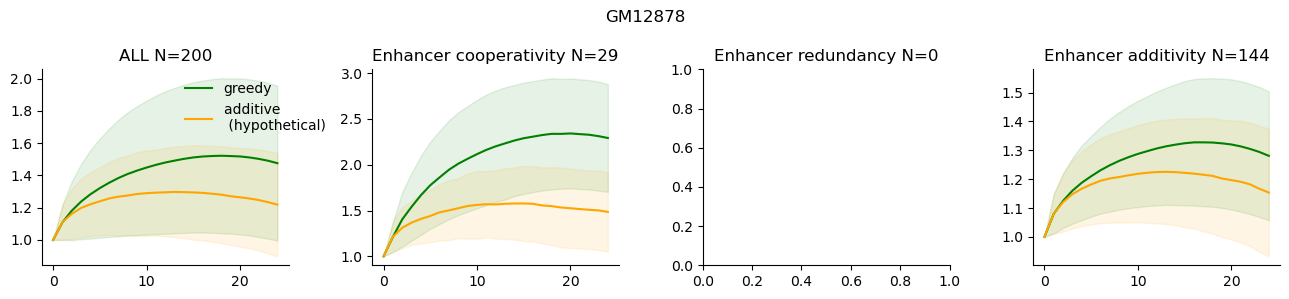

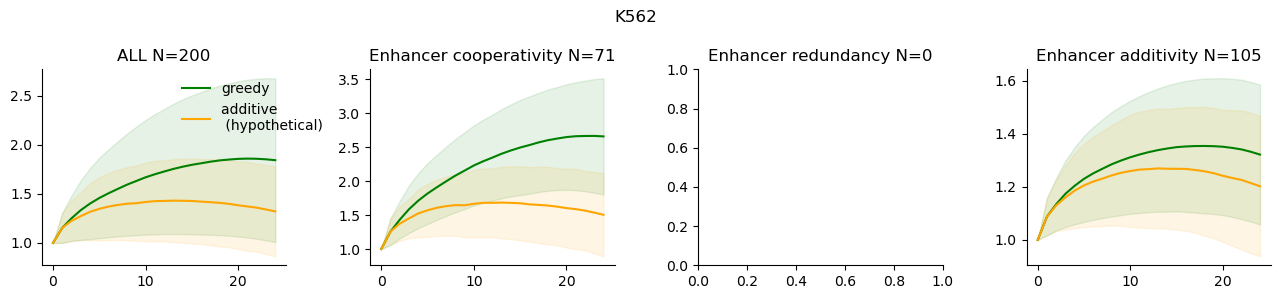

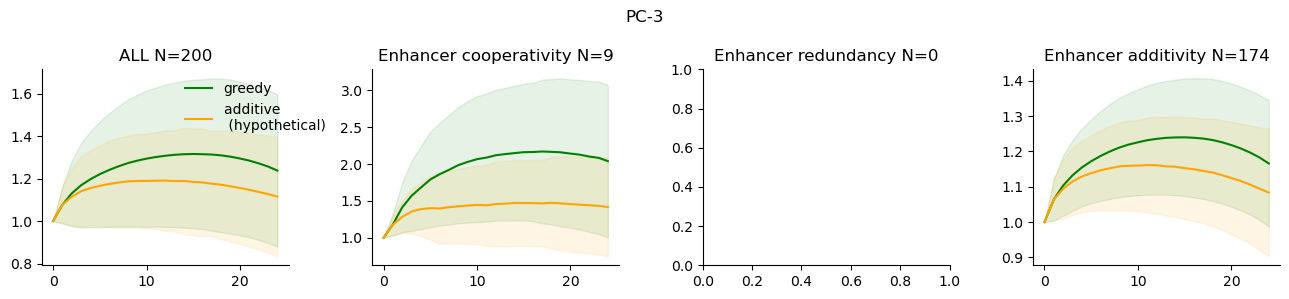

In [44]:
strata = {}
strata_seq_ids = []
for cell_line, cell_df in all_traces.groupby('cell_line'):
    sign = []
    MSE = []
    cell_enhancing_df = cell_df[cell_df['context']=='enhancing']
    L = cell_enhancing_df.shape[0]
    enhancing_greedy = cell_enhancing_df['trace'].values.reshape(L//N_iters, N_iters)
    enhancing_hyp = cell_enhancing_df['hypothetical_trace'].values.reshape(L//N_iters, N_iters)
    for trace, hypothetical_trace in zip(enhancing_greedy, enhancing_hyp):
        MSE.append(mean_squared_error(trace, hypothetical_trace))
        sign.append(np.mean(trace) - np.mean(hypothetical_trace))
    MSE = np.array(MSE) 

    colors = ['green', 'orange']
    labels = ['cooperative', 'additive']
    titles = ['ALL', 'Enhancer cooperativity', 'Enhancer redundancy', 'Enhancer additivity']
    # i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
    
    pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.1]
    neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.1]
    zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
    seq_ids = cell_enhancing_df['seq_id'].values.reshape(L//N_iters, N_iters)[:,0]
    strata[cell_line] = {'cooperativity': pos_points, 'redundancy': neg_points, 'additivity': zero_points}
    for label_stratum, point_indexes in strata[cell_line].items():
        df_per_stratum = pd.DataFrame(seq_ids[point_indexes])
        df_per_stratum.columns = ['seq_id']
        df_per_stratum['cell_line'] = cell_line
        df_per_stratum['label'] = label_stratum
        strata_seq_ids.append(df_per_stratum)
    all_points = np.arange(len(sign))

    fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])
    curve_labels = ['greedy', 'additive \n (hypothetical)']
    
    for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
        ax = axes[p]
        ax.set_title(f'{titles[p]} N={len(points)}')
        trace_set, hypothetical_trace_set = enhancing_greedy[points], enhancing_hyp[points]
        for i, t in enumerate([trace_set, hypothetical_trace_set]):
            if len(t) > 0:
                t_mean = t.mean(axis=0)
                t_std = t.std(axis=0)
                ax.plot(t_mean, color=colors[i], alpha=1, label=curve_labels[i])
            
                ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
    axes[0].legend(frameon=False, bbox_to_anchor=[1.2,1])
    plt.suptitle(cell_line)
    plt.tight_layout()
    # fig.savefig(f'{pdf_dir}/silencer_{cell_line}_greedy_vs_additive.pdf')
strata_seq_ids = pd.concat(strata_seq_ids)